# 机器学习在天文学上的应用（分类)

- 恒星与类星体分类

** 导入模块 **

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from astropy.io import fits 

from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import time

#warnings
import warnings
warnings.filterwarnings('ignore')

** 加载数据 **

In [8]:
quasars = np.load('../DATA/dr7_quasar.npy')
hdulist = fits.open('../DATA/SDSSssppDR9_rerun122.fit')
stars = np.asarray(hdulist[1].data)

In [9]:
# Truncate data for speed
quasars = quasars[::5]
stars = stars[::5]

In [46]:
#quasars

In [47]:
#stars

** 数据预处理 **

In [48]:
Nqso = len(quasars)
Nstars = len(stars)

In [49]:
X = np.empty((Nqso + Nstars, 4), dtype=float)

X[:Nqso, 0] = quasars['mag_u'] - quasars['mag_g']
X[:Nqso, 1] = quasars['mag_g'] - quasars['mag_r']
X[:Nqso, 2] = quasars['mag_r'] - quasars['mag_i']
X[:Nqso, 3] = quasars['mag_i'] - quasars['mag_z']

X[Nqso:, 0] = stars['upsf'] - stars['gpsf']
X[Nqso:, 1] = stars['gpsf'] - stars['rpsf']
X[Nqso:, 2] = stars['rpsf'] - stars['ipsf']
X[Nqso:, 3] = stars['ipsf'] - stars['zpsf']

In [50]:
y = np.zeros(Nqso + Nstars, dtype=int)
y[:Nqso] = 1

** 训练集和测试集**

In [13]:
def split_samples(X, y, fractions=[0.75, 0.25], random_state=0):
    X = np.asarray(X)
    y = np.asarray(y)

    if X.shape[0] != y.shape[0]:
        raise ValueError("X and y should have the same leading dimension")
    n_samples = X.shape[0]

    fractions = np.asarray(fractions).ravel().cumsum()
    fractions /= fractions[-1]
    fractions *= n_samples
    N = np.concatenate([[0], fractions.astype(int)])
    N[-1] = n_samples  # in case of roundoff errors

    random_state = np.random.RandomState(random_state)
    indices = np.arange(len(y))
    random_state.shuffle(indices)

    X_divisions = tuple(X[indices[N[i]:N[i + 1]]]
                        for i in range(len(fractions)))
    y_divisions = tuple(y[indices[N[i]:N[i + 1]]]
                        for i in range(len(fractions)))

    return X_divisions, y_divisions

In [14]:
# split into training and test sets
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.9, 0.1],
                                                     random_state=0)

** 训练模型 **

In [54]:
# Compute fits for all the classifiers
def compute_models(*args):
    names = []
    probs = []

    for classifier, kwargs in args:
        model = classifier(**kwargs)
        model.fit(X, y)
        y_prob = model.predict(X_test)

        names.append(classifier.__name__)
        probs.append(y_prob)

    return names, probs

** 模型预测 **

In [55]:
LRclass_weight = dict([(i, np.sum(y_train == i)) for i in (0, 1)])

names, probs = compute_models((SVC, dict(C=1000.0, kernel='rbf')),
                              (LogisticRegression, dict(class_weight=LRclass_weight)),
                              (KNeighborsClassifier, dict(n_neighbors=10)),
                              (DecisionTreeClassifier, dict(random_state=0, max_depth=12, criterion='entropy')),
                              (GaussianNB, {}),
                              (RandomForestClassifier, dict(n_estimators=1000,random_state=33)))


** 画图 **

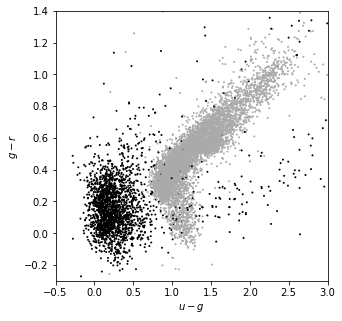

In [56]:
# Plot results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)

# First axis shows the data
ax1 = fig.add_subplot(121)
im = ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=4,
                 linewidths=0, edgecolors='none',
                 cmap=plt.cm.binary)
im.set_clim(-0.5, 1)
ax1.set_xlim(-0.5, 3.0)
ax1.set_ylim(-0.3, 1.4)
ax1.set_xlabel('$u - g$')
ax1.set_ylabel('$g - r$')


plt.show()

** 结果 **

In [57]:
def result(names, probs):
    for i in range(len(names)):
        sum = 0
        for a, y in zip(probs[i], y_test):
            if a == y:
                sum = sum + 1
        print ("%s:\n %s of %s test values correct.\ntest accuracy: %f\n" % (names[i], sum, len(y_test), sum / len(y_test))) 

In [58]:
result(names, probs)

SVC:
 8587 of 8661 test values correct.
test accuracy: 0.991456

LogisticRegression:
 8167 of 8661 test values correct.
test accuracy: 0.942963

KNeighborsClassifier:
 8593 of 8661 test values correct.
test accuracy: 0.992149

DecisionTreeClassifier:
 8608 of 8661 test values correct.
test accuracy: 0.993881

GaussianNB:
 8057 of 8661 test values correct.
test accuracy: 0.930262

RandomForestClassifier:
 8661 of 8661 test values correct.
test accuracy: 1.000000

